In [1]:
import numpy as np
import pandas as pd
import subprocess
import argparse

# Preprocessing CareerBuilder 2012

For the CareerBuilder 2012 dataset we first need to artificially create sessions out of the user internactions

In [2]:
def make_sessions(data, 
                  session_th=30 * 60, 
                  is_ordered=False, 
                  user_key='user_id', 
                  item_key='item_id', 
                  time_key='ts'):
    """Assigns session ids to the events in data without grouping keys"""
    if not is_ordered:
        # sort data by user and time
        data.sort_values(by=[user_key, time_key], ascending=True, inplace=True)
    # compute the time difference between queries
    tdiff = np.diff(data[time_key].values)
    # check which of them are bigger then session_th
    split_session = tdiff > session_th
    split_session = np.r_[True, split_session]
    # check when the user chenges is data
    new_user = data['user_id'].values[1:] != data['user_id'].values[:-1]
    new_user = np.r_[True, new_user]
    # a new sessions stars when at least one of the two conditions is verified
    new_session = np.logical_or(new_user, split_session)
    # compute the session ids
    session_ids = np.cumsum(new_session)
    data['session_id'] = session_ids
    return data

# Test set

A test set can be either created by (1) adding the last session of every user to be tested or, (2) making a time-based split.

In [3]:
def last_session_out_split(data,
                           user_key='user_id',
                           item_key='item_id',
                           session_key='session_id',
                           time_key='ts',
                           clean_test=True,
                           min_session_length=2):
    """
    last-session-out split
    assign the last session of every user to the test set and the remaining ones to the training set
    """
    sessions = data.sort_values(by=[user_key, time_key]).groupby(user_key)[session_key]
    last_session = sessions.last()
    train = data[~data.session_id.isin(last_session.values)].copy()
    test = data[data.session_id.isin(last_session.values)].copy()
    if clean_test:
        train_items = train[item_key].unique()
        test = test[test[item_key].isin(train_items)]
        #  remove sessions in test shorter than min_session_length
        slen = test[session_key].value_counts()
        good_sessions = slen[slen >= min_session_length].index
        test = test[test[session_key].isin(good_sessions)].copy()
    return train, test

In [4]:
def last_n_days_out_split(data, n=1,
                          user_key='user_id',
                          item_key='item_id',
                          session_key='session_id',
                          time_key='ts',
                          clean_test=True,
                          min_session_length=2):
    """
    last n-days out split
    assign the sessions in the last n days to the test set and remaining to the training one
    """
    DAY = 24 * 60 * 60
    data.sort_values(by=[user_key, time_key], inplace=True)
    # start times of all sessions
    #sessions_start = data.groupby(session_key)[time_key].agg('min')
    # extract test start and end time
    end_time = data[time_key].max()
    test_start = end_time - n * DAY
    
    # get train and test indicies
    session_max_times = data.groupby(session_key)[time_key].max()
    session_train = session_max_times[session_max_times < test_start].index
    session_test = session_max_times[session_max_times >= test_start].index
    
    # in1d: Returns a boolean array the same length as ar1 that is True where 
    # an element of ar1 is in ar2 and False otherwise.
    train = data[
        np.in1d(
            data[session_key], 
            session_train
        )
    ].copy()
    test = data[
        np.in1d(
            data[session_key], 
            session_test
        )
    ].copy()

    #train = data[data.session_id.isin(sessions_start[sessions_start < test_start].index)].copy()
    #test = data[data.session_id.isin(sessions_start[sessions_start >= test_start].index)].copy()
    if clean_test:
        before_items = len(test[item_key].unique())
        # remove items which do not occur in the test set
        test = test[np.in1d(test[item_key], train[item_key])]
        after_items = len(test[item_key].unique())
        print("Before item count: " + str(before_items))
        print("After item count: " + str(after_items))
        
        #  remove sessions in test shorter than min_session_length
        
        tslength = test.groupby(session_key).size()
        test = test[
           np.in1d(
                test[session_key], 
                tslength[tslength >= min_session_length].index
            )
        ].copy()
    

    return train, test

#  1. Career Builder 12 processing

In [5]:
path =  "../../data/"
dataset = "cb12/"

raw_path = path + dataset + "raw/" 
interim_path = path + dataset + "interim/"
processed_path = path + dataset + "processed/"

For the Kaggle Career Builder 2012 dataset:
* Only have the **application** interaction is available

Sessions are partitioned by a **30-minute** idle time

Keep all sessions: users with >= 1 sessions and also overly active ones (< 200,000 sessions)

Link to dataset: https://www.kaggle.com/c/job-recommendation/data

In [12]:
interactions = pd.read_csv(raw_path + "apps.tsv", header=0, sep='\t')
interactions = interactions.rename(columns={"UserID": "user_id", "JobID": "item_id", "ApplicationDate": "created_at"})
interactions["interaction_type"] = 0 # no different interactions
interactions = interactions.drop(columns=["WindowID", "Split"])
interactions['created_at'] = interactions['created_at'].astype("datetime64[ms]").astype(np.int64) // 10**9
interactions.to_csv(raw_path + "interactions.csv", sep='\t')
interactions.head()

,user_id,created_at,item_id,interaction_type
0,47,1333554983,169528,0
1,47,1333674180,284009,0
2,47,1333593627,2121,0
3,47,1333593422,848187,0
4,47,1333665846,733748,0


In [13]:
print("Start Time: {}".format(pd.to_datetime(interactions["created_at"].min(), unit="s")))
print("Start Time: {}".format(pd.to_datetime(interactions["created_at"].max(), unit="s")))

# remove NaN values
interactions = interactions[np.isfinite(interactions['created_at'])]
# convert back to long from float
interactions['created_at'] = interactions['created_at'].astype(np.int64)


interactions['interaction_type'] = interactions['interaction_type'].fillna(0).astype('int')


print('Building sessions')
# partition interactions into sessions with 30-minutes idle time
interactions = make_sessions(interactions, session_th=30 * 60, time_key='created_at', is_ordered=False)


print(interactions.head(3))
# drop duplicate interactions
interactions = interactions.drop_duplicates(['session_id','created_at'])

print('Original data:')
print('Num items: {}'.format(interactions.item_id.nunique()))
print('Num users: {}'.format(interactions.user_id.nunique()))
print('Num sessions: {}'.format(interactions.session_id.nunique()))

print('Filtering data')
# drop duplicate interactions within the same session
interactions.drop_duplicates(subset=['item_id', 'session_id', 'interaction_type'], keep='first', inplace=True)

# keep items with >=1 interactions
item_pop = interactions.item_id.value_counts()
#good_items = item_pop[item_pop >= 5].index
good_items = item_pop[item_pop >= 1].index

inter_dense = interactions[interactions.item_id.isin(good_items)]

# remove sessions with length < 3
session_length = inter_dense.session_id.value_counts()
good_sessions = session_length[session_length >= 3].index
inter_dense = inter_dense[inter_dense.session_id.isin(good_sessions)]

# let's keep only returning users (with >= 5 sessions) and remove overly active ones (>=200 sessions)
sess_per_user = inter_dense.groupby('user_id')['session_id'].nunique()
good_users = sess_per_user[(sess_per_user >= 1) & (sess_per_user < 200000)].index
inter_dense = inter_dense[inter_dense.user_id.isin(good_users)]
print('Filtered data:')
print('Num items: {}'.format(inter_dense.item_id.nunique()))
print('Num users: {}'.format(inter_dense.user_id.nunique()))
print('Num sessions: {}'.format(inter_dense.session_id.nunique()))

inter_dense.to_csv(interim_path + "interactions.csv", sep='\t')

Start Time: 2012-04-01 00:00:21
Start Time: 2012-06-26 23:59:55
Building sessions
        user_id  created_at  item_id  interaction_type  session_id
563238        7  1335082466   309823                 0           1
563239        7  1335615478   703889                 0           2
780806        9  1337034642   809208                 0           3
Original data:
Num items: 354303
Num users: 321235
Num sessions: 639534
Filtering data
Filtered data:
Num items: 213445
Num users: 91547
Num sessions: 123746


# 2. Create train and test set by doing a time-based (2 weeks) split

In [9]:
print('Partitioning data')
# last-session-out partitioning
train_full_sessions, test_sessions = last_n_days_out_split(inter_dense, n=14,
                                                            user_key='user_id',
                                                            item_key='item_id',
                                                            session_key='session_id',
                                                            time_key='created_at',
                                                            clean_test=True)
train_valid_sessions, valid_sessions = last_n_days_out_split(train_full_sessions, n=14,
                                                              user_key='user_id',
                                                              item_key='item_id',
                                                              session_key='session_id',
                                                              time_key='created_at',
                                                              clean_test=True)

Partitioning data
Before item count: 13950
After item count: 9747
Before item count: 21225
After item count: 11935


In [10]:
# print statistics

train_len = len(train_full_sessions.session_id.unique())
train_item_len = len(train_full_sessions.item_id.unique())

test_len = len(test_sessions.session_id.unique())
test_item_len = len(test_sessions.item_id.unique())

merged_items = train_full_sessions.append(test_sessions, ignore_index=True)
merged_item_len = len(merged_items.item_id.unique())

print("Training - Sessions: " + str(train_len))
print("Testing - Sessions: " + str(test_len))
print("Train + Test - Sessions: " + str(train_len + test_len))

print("Training - Items: " + str(train_item_len))
print("Testing - Items: " + str(test_len))
print("Train + Test - Items: " + str(merged_item_len))


print("Train Validating - Sessions: " + str(len(train_valid_sessions.session_id.unique())))
print("Test Validating - Sessions: " + str(len(valid_sessions.session_id.unique())))

Training - Sessions: 66348
Testing - Sessions: 9632
Train + Test - Sessions: 75980
Training - Items: 60916
Testing - Items: 9632
Train + Test - Items: 60916
Train Validating - Sessions: 51717
Test Validating - Sessions: 10574


# 3. Store train and test sets

In [10]:
train_full_sessions.to_csv(processed_path + "train_14d.csv", sep='\t')
test_sessions.to_csv(processed_path + "test_14d.csv", sep='\t')
train_valid_sessions.to_csv(processed_path + "valid_train_14d.csv", sep='\t')
valid_sessions.to_csv(processed_path + "valid_test_14d.csv", sep='\t')

# 4. Create train and test session vectors

In [11]:
# Create vocabulary from train set
unqiue_train_items = train_full_sessions.item_id.unique()
# store (or load)
unqiue_train_items_df = pd.DataFrame(unqiue_train_items, columns=["item_id"])
print(len(unqiue_train_items_df))
#unqiue_train_items_df.to_csv(interim_path + 'vocabulary_min_5_app.csv', header=True)
unqiue_train_items_df.to_csv(interim_path + 'vocabulary.csv', header=True)
unqiue_train_items_df = pd.read_csv(interim_path + 'vocabulary.csv', index_col=0)

60916


In [13]:
unqiue_train_items_dict = unqiue_train_items_df.to_dict('dict')["item_id"]
# inverse that item_id is key and index is value
unqiue_train_items_dict_inv = {v: k for k, v in unqiue_train_items_dict.items()}

# session_vectors = []
# session_groups = train_full_sessions.groupby("session_id")
session_ids = train_full_sessions.session_id.unique()

In [ ]:
print(str(len(session_ids)) + " sessions to encode.")
s_counter = 0
file_name = interim_path + 'train_session_interaction_vector.csv'
with open(file_name, "w") as file:
    header = ",".join(map(str, range(len(unqiue_train_items))))
    file.write(header + "\n")
    for session_id in session_ids:
        session_group = train_full_sessions[train_full_sessions["session_id"] == session_id]
        # vector length = len(unqiue_train_items)
        session_vector = np.zeros((len(unqiue_train_items),), dtype=int)
        # fill 1s for session items
        for index, row in session_group.iterrows():
            item_index = unqiue_train_items_dict_inv[row["item_id"]]
            # 1-hot encode
            session_vector[item_index] = 1
        # append session vector
        session_vector_with_index = np.insert(session_vector, 0, s_counter)
        session_vector_with_index_string = ",".join(map(str,session_vector_with_index))
        file.write(session_vector_with_index_string + "\n")
        s_counter += 1
        if (s_counter % 1000 == 0):
            print(str(len(session_ids) - s_counter) + " sessions remaining to encode.")


108783 sessions to encode.
107783 sessions remaining to encode.
106783 sessions remaining to encode.
105783 sessions remaining to encode.
104783 sessions remaining to encode.
103783 sessions remaining to encode.
102783 sessions remaining to encode.
101783 sessions remaining to encode.
100783 sessions remaining to encode.
99783 sessions remaining to encode.
98783 sessions remaining to encode.
97783 sessions remaining to encode.
96783 sessions remaining to encode.
95783 sessions remaining to encode.
94783 sessions remaining to encode.
93783 sessions remaining to encode.
92783 sessions remaining to encode.
91783 sessions remaining to encode.
90783 sessions remaining to encode.
89783 sessions remaining to encode.
88783 sessions remaining to encode.
87783 sessions remaining to encode.
86783 sessions remaining to encode.
85783 sessions remaining to encode.
84783 sessions remaining to encode.
83783 sessions remaining to encode.
82783 sessions remaining to encode.
81783 sessions remaining to e

# Statistics

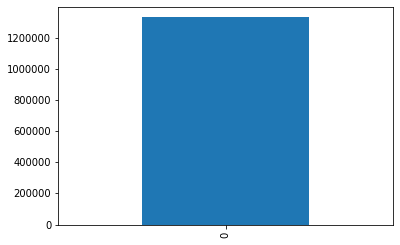

In [18]:
import matplotlib.pyplot as plt
interactions.interaction_type.value_counts().plot(kind='bar')
plt.show()

In [17]:
print('Train Num items: {}'.format(train_full_sessions.item_id.nunique()))
print('Train Num sessions: {}'.format(train_full_sessions.session_id.nunique()))
print('Train Num events: {}'.format(len(train_full_sessions)))
print('Test Num items: {}'.format(test_sessions.item_id.nunique()))
print('Test Num sessions: {}'.format(test_sessions.session_id.nunique()))
print('Test Num events: {}'.format(len(test_sessions)))


Train Num items: 197590
Train Num sessions: 108783
Train Num events: 599946
Test Num items: 13361
Test Num sessions: 11364
Test Num events: 61964


In [8]:
interactions = pd.read_csv("../../data/cb12/raw/interactions.csv", header=0, sep='\t')

# remove NaN values
interactions = interactions[np.isfinite(interactions['created_at'])]
# convert back to long from float
interactions['created_at'] = interactions['created_at'].astype(np.int64)

interactions['interaction_type'] = interactions['interaction_type'].fillna(0).astype('int')

print('Building sessions')
# partition interactions into sessions with 30-minutes idle time
interactions = make_sessions(interactions, session_th=30 * 60, time_key='created_at', is_ordered=False)


print(interactions.head(3))
# drop duplicate interactions
interactions = interactions.drop_duplicates(['item_id','session_id','created_at'])

print('Original data:')
print('Num items: {}'.format(interactions.item_id.nunique()))
print('Num users: {}'.format(interactions.user_id.nunique()))
print('Num sessions: {}'.format(interactions.session_id.nunique()))

print('Filtering data')
# keep items with >=20 interactions
item_pop = interactions.item_id.value_counts()
good_items = item_pop[item_pop >= 1].index
inter_dense = interactions[interactions.item_id.isin(good_items)]
# remove sessions with length < 3
session_length = inter_dense.session_id.value_counts()
good_sessions = session_length[session_length >= 3].index
inter_dense = inter_dense[inter_dense.session_id.isin(good_sessions)]
# let's keep only returning users (with >= 5 sessions) and remove overly active ones (>=200 sessions)
sess_per_user = inter_dense.groupby('user_id')['session_id'].nunique()
good_users = sess_per_user[(sess_per_user >= 1) & (sess_per_user < 200000)].index
inter_dense = inter_dense[inter_dense.user_id.isin(good_users)]
print('Filtered data:')
print('Num items: {}'.format(inter_dense.item_id.nunique()))
print('Num users: {}'.format(inter_dense.user_id.nunique()))
print('Num sessions: {}'.format(inter_dense.session_id.nunique()))

store_path = "../../data/cb12/"
inter_dense.to_csv(store_path + "filtered.csv", sep='\t')

print('Partitioning data')
# last-session-out partitioning
train_full_sessions, test_sessions = last_n_days_out_split(inter_dense, n=14,
                                                            user_key='user_id',
                                                            item_key='item_id',
                                                            session_key='session_id',
                                                            time_key='created_at',
                                                            clean_test=True)
train_valid_sessions, valid_sessions = last_n_days_out_split(train_full_sessions, n=14,
                                                              user_key='user_id',
                                                              item_key='item_id',
                                                              session_key='session_id',
                                                              time_key='created_at',
                                                              clean_test=True)

print("Data - Sessions: " + str(len(inter_dense.session_id.unique())))
print("Training - Sessions: " + str(len(train_full_sessions.session_id.unique())))
print("Testing - Sessions: " + str(len(test_sessions.session_id.unique())))
print("Train Validating - Sessions: " + str(len(train_valid_sessions.session_id.unique())))
print("Test Validating - Sessions: " + str(len(valid_sessions.session_id.unique())))

train_full_sessions.to_csv(store_path + "train_d14.csv", sep='\t')
test_sessions.to_csv(store_path + "test_d14.csv", sep='\t')
train_valid_sessions.to_csv(store_path + "valid_train_d14.csv", sep='\t')
valid_sessions.to_csv(store_path + "valid_test_d14.csv", sep='\t')

print('Train Num items: {}'.format(train_full_sessions.item_id.nunique()))
print('Train Num sessions: {}'.format(train_full_sessions.session_id.nunique()))
print('Train Num events: {}'.format(len(train_full_sessions)))
print('Test Num items: {}'.format(test_sessions.item_id.nunique()))
print('Test Num sessions: {}'.format(test_sessions.session_id.nunique()))
print('Test Num events: {}'.format(len(test_sessions)))

Building sessions
        Unnamed: 0  user_id  created_at  item_id  interaction_type  session_id
563238      563238        7  1335082466   309823                 0           1
563239      563239        7  1335615478   703889                 0           2
780806      780806        9  1337034642   809208                 0           3
Original data:
Num items: 365668
Num users: 321235
Num sessions: 639534
Filtering data
Filtered data:
Num items: 233737
Num users: 100995
Num sessions: 139379
Partitioning data
Before item count: 29906
After item count: 14241
Before item count: 44612
After item count: 17775
Data - Sessions: 139379
Training - Sessions: 124222
Testing - Sessions: 11743
Train Validating - Sessions: 104016
Test Validating - Sessions: 13088
Train Num items: 218072
Train Num sessions: 124222
Train Num events: 892697
Test Num items: 13931
Test Num sessions: 11743
Test Num events: 66726
